## JPLDD Demo Notebook
In this notebook we demonstrate the functionality of JPLDD. Using a single image we show how to action: 1) Heatmap generation, 2) Keypoint detection, 3) Line Detection, 4) Descriptor extraction

In [111]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import Resize
from pytlsd import lsd
import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, '..'))
from gluefactory.models import get_model
from gluefactory.models.extractors.jpldd.line_detection_jpldd import detect_jpldd_lines
from sklearn.decomposition import PCA

In [112]:
plt.rcParams["figure.figsize"] = (7,7)

In [113]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
device = 'cpu'
device

'cpu'

In [114]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

Import and visualize demo picture

torch.Size([1, 3, 568, 1024])


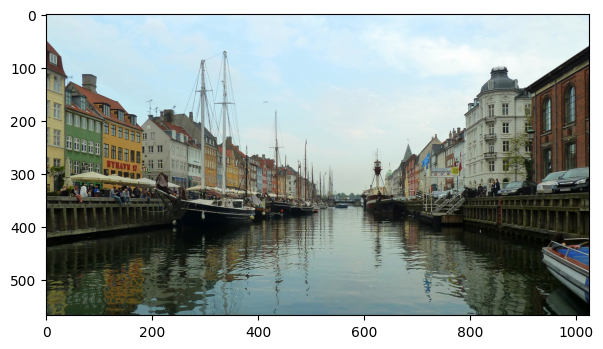

In [115]:
size = (800,800)

resize_func = Resize(size)
#image_path = f"demo_louvre.jpg"
image_path = f"/home/egoedeke/Downloads/revisitop1m_POLD2/jpg/0a0/0a0c7d23eef7f7b5a82ca52580c184/base_image.jpg"
#img = cv2.resize(cv2.imread(image_path),size)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_torch = numpy_image_to_torch(img).to(device)
img_torch = img_torch.unsqueeze(0)

print(img_torch.shape)
plt.imshow(rgb_img)
plt.show()

## 1) JPLDD Heatmaps

In [127]:
jpldd_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "max_num_keypoints": 1024,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": False
    },
    # "checkpoint": None
}
jpldd_model = get_model("jpldd.joint_point_line_extractor")(jpldd_conf).to(device)
jpldd_model.eval()

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [128]:
%%time

with torch.no_grad():
    output_jpldd = jpldd_model({"image": img_torch})
output_jpldd.keys()

CPU times: user 8.74 s, sys: 4.86 s, total: 13.6 s
Wall time: 1.79 s


dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [129]:
jpldd_kpjhm = output_jpldd['keypoint_and_junction_score_map'][0]
jpldd_af = output_jpldd['line_anglefield'][0]
jpldd_df = output_jpldd['line_distancefield'][0]
jpldd_kpr = output_jpldd['keypoints_raw'][0]
jpldd_kp = output_jpldd['keypoints'][0]
jpldd_kp_scores = output_jpldd['keypoint_scores'][0]
jpldd_desc = output_jpldd['descriptors'][0]

jpldd_kpjhm.shape, jpldd_af.shape, jpldd_df.shape, jpldd_kpr.shape, jpldd_kp.shape, jpldd_kp_scores.shape, jpldd_desc.shape

(torch.Size([568, 1024]),
 torch.Size([568, 1024]),
 torch.Size([568, 1024]),
 torch.Size([1024, 2]),
 torch.Size([1024, 2]),
 torch.Size([1024]),
 torch.Size([1024, 128]))

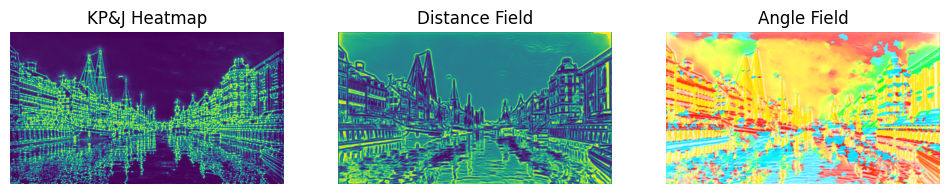

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].axis('off')
ax[0].set_title('KP&J Heatmap')
ax[0].imshow(jpldd_kpjhm)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(jpldd_df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(jpldd_df, jpldd_af))
plt.show()

## 2) Keypoint detection

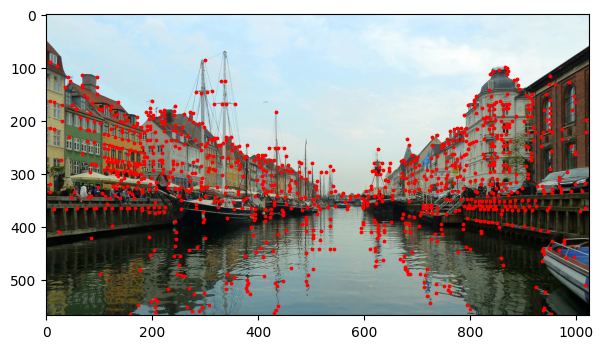

In [131]:
plt.imshow(rgb_img)
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c='r', s=3)
plt.show()

(798, 2)


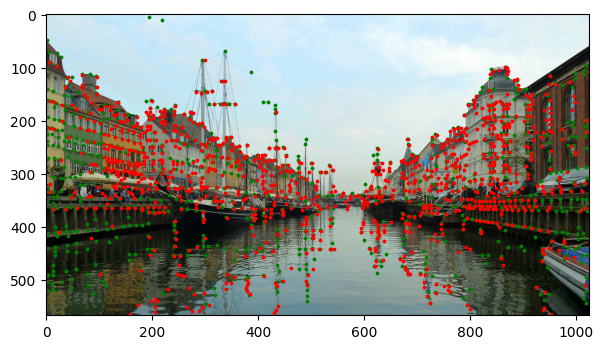

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load keypoints and image paths
keypoint_path = '/home/egoedeke/Downloads/revisitop1m_POLD2/jpg/0a0/0a0c7d23eef7f7b5a82ca52580c184/keypoints.npy'
image_path = '/home/egoedeke/Downloads/revisitop1m_POLD2/jpg/0a0/0a0c7d23eef7f7b5a82ca52580c184/base_image.jpg'
kpnt_scores_path = '/home/egoedeke/Downloads/revisitop1m_POLD2/jpg/0a0/0a0c7d23eef7f7b5a82ca52580c184/keypoint_scores.npy'


# Load keypoints
keypoints = np.load(keypoint_path)

# print no of keypoints
print(keypoints.shape)

# Load image
rgb_img = Image.open(image_path)
rgb_img = np.array(rgb_img)




# Image dimensions
height, width, _ = rgb_img.shape

# Resize the keypoints to the image size
# Ensure the original size matches the size used when keypoints were computed
original_width = 800  # Change to the original width if different
original_height = 800  # Change to the original height if different

#keypoints[:, 0] = keypoints[:, 0] * original_width / width
#keypoints[:, 1] = keypoints[:, 1] * original_height / height

# resize rgb image to 800x800
#rgb_img = cv2.resize(rgb_img, (800, 800))

# Plot keypoints on the image
plt.imshow(rgb_img)
plt.scatter(keypoints[:, 0], keypoints[:, 1], c='g', s=3)
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c='r', s=3)

# Assuming jpldd_kp is already defined and loaded
# jpldd_kp = np.load('path_to_jpldd_keypoints.npy')  # Example loading jpldd keypoints
# plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c='r', s=3)
plt.show()



In [137]:
import argparse
from pathlib import Path

import cv2
import h5py
import numpy as np
import torch
from joblib import Parallel, delayed
from kornia.geometry.transform import warp_perspective
from kornia.morphology import erosion
from omegaconf import OmegaConf
from tqdm import tqdm

from gluefactory.datasets import get_dataset
from gluefactory.geometry.homography import sample_homography_corners
from gluefactory.models.extractors.superpoint_open import SuperPoint
from gluefactory.settings import EVAL_PATH

conf = {
    "patch_shape": [800, 800],
    "difficulty": 0.8,
    "translation": 1.0,
    "n_angles": 10,
    "max_angle": 60,
    "min_convexity": 0.05,
}

sp_conf = {
    "max_num_keypoints": None,
    "nms_radius": 4,
    "detection_threshold": 0.005,
    "remove_borders": 4,
    "descriptor_dim": 256,
    "channels": [64, 64, 128, 128, 256],
    "dense_outputs": None,
    "weights": None,  # local path of pretrained weights
}

H_params = {
    "difficulty": 0.8,
    "translation": 1.0,
    "max_angle": 60,
    "n_angles": 10,
    "min_convexity": 0.05,
}

ha = {
    "enable": False,
    "num_H": 100,
    "mini_bs": 3,
    "aggregation": "mean",
}

homography_params = {
    "translation": True,
    "rotation": True,
    "scaling": True,
    "perspective": True,
    "scaling_amplitude": 0.2,
    "perspective_amplitude_x": 0.2,
    "perspective_amplitude_y": 0.2,
    "patch_ratio": 0.85,
    "max_angle": 1.57,
    "allow_artifacts": True,
}

In [138]:


def get_dataset_and_loader(num_workers):  # folder where dataset images are placed
    config = {
        "name": "minidepth",  # name of dataset class in gluefactory > datasets
        "grayscale": True,  # commented out things -> dataset must also have these keys but has not
        "preprocessing": {"resize": [800, 800]},
        "train_batch_size": 1,  # prefix must match split mode
        "val_batch_size": 1,  # prefix must match split mode
        "num_workers": num_workers,
        "split": "val",  # if implemented by dataset class gives different splits
    }
    omega_conf = OmegaConf.create(config)
    dataset = get_dataset(omega_conf.name)(omega_conf)
    loader = dataset.get_data_loader(omega_conf.get("split", "val"))
    return loader


def sample_homography(img, conf: dict, size: list):
    data = {}
    H, _, coords, _ = sample_homography_corners(img.shape[:2][::-1], **conf)
    data["image"] = cv2.warpPerspective(img, H, tuple(size))
    data["H_"] = H.astype(np.float32)
    data["coords"] = coords.astype(np.float32)
    data["image_size"] = np.array(size, dtype=np.float32)
    return data


def ha_forward(img, num=100):
    """Perform homography adaptation to regress line distance function maps.
    Args:
        img: a grayscale np image.
        num: number of homographies used during HA.
        border_margin: margin used to erode the boundaries of the mask.
        min_counts: any pixel which is not activated by more than min_count is BG.
    Returns:
        The aggregated distance function maps in pixels
        and the angle to the closest line.
    """
    h, w = img.shape[:2]

    aggregated_heatmap = np.zeros((w, h, num), dtype=np.float32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SuperPoint(sp_conf).to(device)
    model.eval().to(device)

    Hs = []
    for i in range(num):
        if i == 0:
            # Always include at least the identity
            Hs.append(torch.eye(3, dtype=torch.float, device=device))
        else:
            Hs.append(
                torch.tensor(
                    sample_homography_corners((w, h), patch_shape=(w, h), **H_params)[
                        0
                    ],
                    dtype=torch.float,
                    device=device,
                )
            )
    Hs = torch.stack(Hs, dim=0)

    bs = ha["mini_bs"]
    B = 1

    erosion_kernel = torch.tensor(
        [
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
            [0, 0, 1, 0, 0],
        ],
        dtype=torch.float,
    )

    erosion_kernel = erosion_kernel.to(device)

    sp_image_tensor = (
        torch.tensor(img, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    )
    n_mini_batch = int(np.ceil(num / bs))
    scores = torch.empty((B, 0, h, w), dtype=torch.float, device=device)
    counts = torch.empty((B, 0, h, w), dtype=torch.float, device=device)

    for i in range(n_mini_batch):
        H = Hs[i * bs : (i + 1) * bs]
        nh = len(H)
        H = H.repeat(B, 1, 1)
        H = H.to(device)

        a = torch.repeat_interleave(sp_image_tensor, nh, dim=0)
        warped_imgs = warp_perspective(a, H, (h, w), mode="bilinear")

        for j, img in enumerate(warped_imgs):
            with torch.no_grad():
                img1 = img / 255.0  # Normalize image
                img1 = img1.unsqueeze(0)  # Add batch dimension
                pred = model({"image": img1.to(device)})
                pred = {k: v[0].cpu().numpy() for k, v in pred.items()}

                warped_heatmap = pred["heatmap"]

                # convert to pytorch tensor
                score = torch.tensor(
                    warped_heatmap, dtype=torch.float32, device=device
                ).unsqueeze(0)

                # Compute valid pixels
                H_inv = torch.inverse(H[j])

                count = warp_perspective(
                    torch.ones_like(score).unsqueeze(1),
                    H[j].unsqueeze(0),
                    (h, w),
                    mode="nearest",
                )

                count = erosion(count, erosion_kernel)
                count = warp_perspective(
                    count, H_inv.unsqueeze(0), (h, w), mode="nearest"
                )[:, 0]
                score = warp_perspective(
                    score[:, None], H_inv.unsqueeze(0), (h, w), mode="bilinear"
                )[:, 0]

            scores = torch.cat([scores, score.reshape(B, 1, h, w)], dim=1)
            counts = torch.cat([counts, count.reshape(B, 1, h, w)], dim=1)
            scores[counts == 0] = 0
            score = scores.max(dim=1)[0]

            scoremap = score.squeeze(0)
    return scoremap

torch.Size([568, 1024])


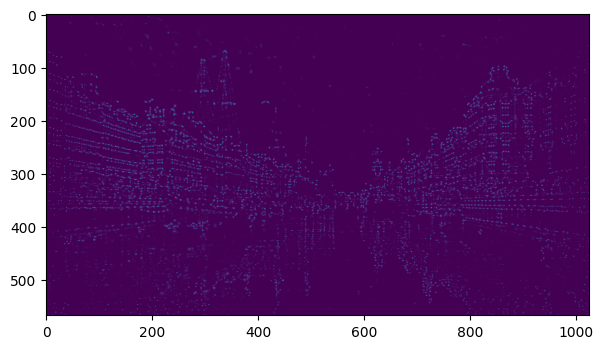

In [142]:
# img = img_data["image"]  # B x C x H x W
# img_npy = img.numpy()
# img_npy = img_npy[0, :, :, :]
# img_npy = np.transpose(img_npy, (1, 2, 0))  # H x W x C
# Run homography adaptation

num_H = 100

# convert to superpoint format: img_npy to 0-255, uint8 and h * w
sp_image = (rgb_img[:, :, 0] * 255).astype(np.uint8)
superpoint_heatmap = ha_forward(sp_image, num=num_H)

# prtin the heatmap shape
print(superpoint_heatmap.shape)
# plot the heatmap


superpoint_heatmap = superpoint_heatmap.cpu()
plt.imshow(superpoint_heatmap)
plt.show()

# # assert len(img_data["name"]) == 1  # Currently expect batch size one!
# # store gt in same structure as images of minidepth

# complete_out_folder = (output_folder_path / str(img_data["name"][0])).parent
# complete_out_folder.mkdir(parents=True, exist_ok=True)
# output_file_path = (
#     complete_out_folder / f"{Path(img_data['name'][0]).name.split('.')[0]}.hdf5"
# )

# # Save the DF in a hdf5 file
# with h5py.File(output_file_path, "w") as f:
#         f.create_dataset("superpoint_heatmap", data=superpoint_heatmap)


In [154]:
kpnt_scores = np.load(kpnt_scores_path)
kpnt_scores.shape



(798,)

## 3) Line Detection

In [133]:
df = jpldd_df
af = jpldd_af
detected_lines = detect_jpldd_lines(
    df, af, jpldd_kp,
    n_samples=64, 
    df_thresh=2, 
    inlier_thresh=0.9,
    a_diff_thresh=np.pi/20,
    a_std_thresh=np.pi/10,
    r_radius = 1,
)
detected_lines.shape

torch.Size([934, 2, 2])

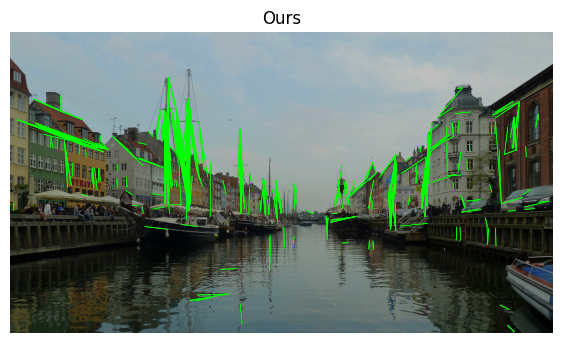

In [134]:
LINE_COLOR = 'lime'
KP_COLOR = 'r'
ALL_KP_COLOR = 'blue'

plt.title('Ours')
plt.axis('off')
# plt.imshow(npdf)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
line_segs = detected_lines
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c=LINE_COLOR, linewidth=0.5)
# plt.scatter(*junctions.T.numpy()[::-1], c=ALL_KP_COLOR, s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c=KP_COLOR, s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c=KP_COLOR, s=5)
# plt.scatter(lines[:1000, 0, 0], lines[:1000, 1, 0], c=KP_COLOR, s=5)
# plt.legend()
plt.show()

## 4) Descriptor extraction

In [135]:
pca = PCA(n_components=3)
pca.fit(jpldd_desc.numpy())

pca_desc = pca.transform(jpldd_desc)

normalized_pca_desc = pca_desc - pca_desc.min()
normalized_pca_desc = normalized_pca_desc / normalized_pca_desc.max()

normalized_pca_desc

array([[0.42982759, 0.58660869, 0.38058925],
       [0.59987321, 0.64029111, 0.37587184],
       [0.2569926 , 0.22516501, 0.48641476],
       ...,
       [0.23882717, 0.43202321, 0.30547623],
       [0.45497939, 0.69956922, 0.74110001],
       [0.39116275, 0.46755225, 0.58427736]])

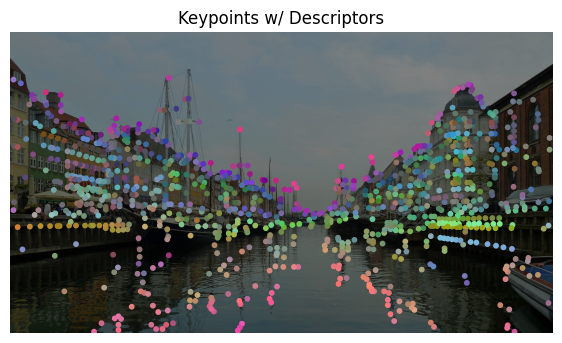

In [136]:
plt.axis('off')
plt.title('Keypoints w/ Descriptors')
plt.imshow(rgb_img)
plt.imshow(np.zeros_like(img), alpha=0.5, cmap='gray')
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c=normalized_pca_desc, s=10)
#plt.savefig('../experiments/data/kpd.png')
plt.show()